In [60]:
#we will import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import sklearn
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score

#importing dataset
from google.colab import drive
drive.mount("/content/drive")
dataset=pd.read_csv("/content/drive/MyDrive/movie.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
dataset.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## **EDA**-Exploratory Data Analysis

In [62]:
dataset.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [63]:
dataset.shape

(40000, 2)

In [64]:
dataset.info

<bound method DataFrame.info of                                                     text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[40000 rows x 2 columns]>

In [65]:
dataset['label'].value_counts()#count of 0s and 1s

label
0    20019
1    19981
Name: count, dtype: int64

In [66]:
#check and drop duplicate values
dataset.duplicated().value_counts()
#277 duplicate entries

False    39723
True       277
Name: count, dtype: int64

In [67]:
dataset.drop_duplicates(inplace=True)
dataset.duplicated().sum()

0

In [68]:
#checking for null values here there are no null vlaues
nullval=dataset.isnull().sum()
nullval

text     0
label    0
dtype: int64

In [69]:
#comparing length of positive and negative reviews separately
pos = dataset[dataset['label']==1]
neg = dataset[dataset['label']==0]
print(len(pos))
print(len(neg))
#imbalanced data

19908
19815


In [70]:
#analysing length of reviews
dataset['length'] = dataset['text'].apply(len)
dataset.head()

,text,label,length
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983


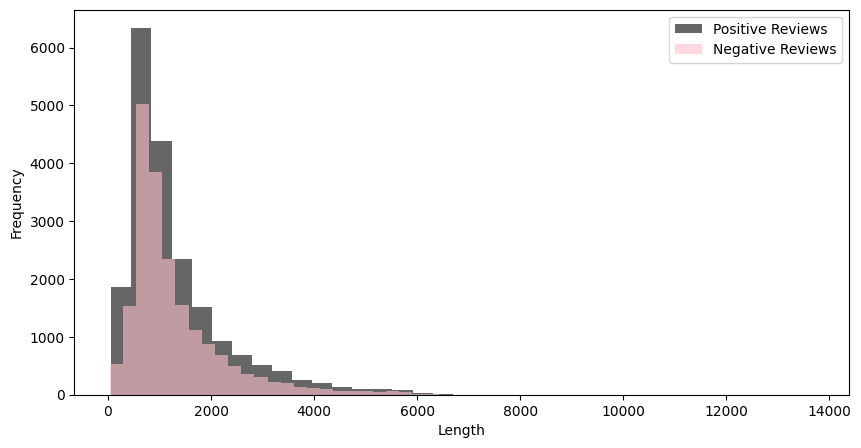

In [71]:
#plotting graphs
plt.figure(figsize=(10,5))
dataset[dataset['label']==1]['length'].plot(bins=35, kind='hist', color='black', label='Positive Reviews', alpha=0.6)
dataset[dataset['label']==0]['length'].plot(bins=35, kind='hist', color='pink', label='Negative Reviews', alpha=0.6)
plt.legend()
plt.xlabel("Length")
plt.show()

<ipython-input-72-14a77764c99b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=dataset, palette='hls')


<Axes: xlabel='label', ylabel='count'>

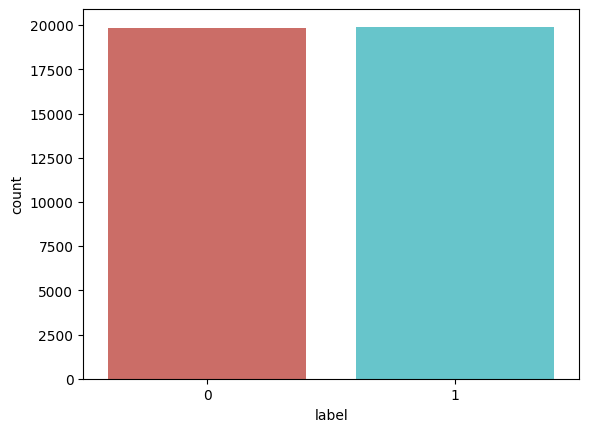

In [72]:
sns.countplot(x='label', data=dataset, palette='hls')

## **PRE**-**PROCESSING DATA**

In [73]:
#converting text to lowercase
dataset['text'] = dataset['text'].apply(lambda x: x.lower())

In [74]:
#stopword removal
from nltk.corpus import stopwords
nltk.download('stopwords')
Stopwords = stopwords.words('english') #stopword corpus
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in Stopwords])
dataset['text'] = dataset['text'].apply(lambda text: remove_stopwords(text))
dataset.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,length
0,grew (b. 1965) watching loving thunderbirds. m...,0,874
1,"put movie dvd player, sat coke chips, expectat...",0,1811
2,people know particular time past like feel nee...,0,983
3,"even though great interest biblical movies, bo...",0,351
4,im die hard dads army fan nothing ever change ...,1,983


In [75]:
#removes all the special characters which are not alphabets or spaces like emojis, hashtags, punctuations etc
def rem_sp_ch(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)
dataset['text'] = dataset['text'].apply(lambda text: rem_sp_ch(text))
dataset.head()

,text,label,length
0,grew b watching loving thunderbirds mates sch...,0,874
1,put movie dvd player sat coke chips expectatio...,0,1811
2,people know particular time past like feel nee...,0,983
3,even though great interest biblical movies bor...,0,351
4,im die hard dads army fan nothing ever change ...,1,983


In [76]:
#removing repeating characters
def remove_repeating_chars(text):
    return re.sub(r'(.)\1+', r'\1', text)
dataset['text'] = dataset['text'].apply(lambda text: remove_repeating_chars(text))

In [77]:
dataset.head()


,text,label,length
0,grew b watching loving thunderbirds mates scho...,0,874
1,put movie dvd player sat coke chips expectatio...,0,1811
2,people know particular time past like fel ned ...,0,983
3,even though great interest biblical movies bor...,0,351
4,im die hard dads army fan nothing ever change ...,1,983


In [78]:
#Tokenisation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

0    [grew, b, watching, loving, thunderbirds, mate...
1    [put, movie, dvd, player, sat, coke, chips, ex...
2    [people, know, particular, time, past, like, f...
3    [even, though, great, interest, biblical, movi...
4    [im, die, hard, dads, army, fan, nothing, ever...
Name: text, dtype: object

In [79]:
#Stemming
stemmer = nltk.PorterStemmer()

def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

dataset['text']= dataset['text'].apply(lambda x: stemming(x))
dataset['text'].head()

0    [grew, b, watching, loving, thunderbirds, mate...
1    [put, movie, dvd, player, sat, coke, chips, ex...
2    [people, know, particular, time, past, like, f...
3    [even, though, great, interest, biblical, movi...
4    [im, die, hard, dads, army, fan, nothing, ever...
Name: text, dtype: object

In [80]:
#Lemmatization
nltk.download('wordnet')
lemmatize = nltk.WordNetLemmatizer()

def lemmatizing(data):
    text = [lemmatize.lemmatize(word) for word in data]
    return data

dataset['text']= dataset['text'].apply(lambda x: lemmatizing(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [grew, b, watching, loving, thunderbirds, mate...
1    [put, movie, dvd, player, sat, coke, chips, ex...
2    [people, know, particular, time, past, like, f...
3    [even, though, great, interest, biblical, movi...
4    [im, die, hard, dads, army, fan, nothing, ever...
Name: text, dtype: object

In [93]:
#test train split after separating variables
X=dataset.text
Y=dataset.label
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=5000)
#it splits the data in the ratio of 70-30% where 30 is the testing part
#random state ensures the splitting is consistent throughout that is maintains a constant ratio

In [82]:
print(X_train)

29541    [cher, films, fil, subject, mater, gaps, world...
17769    [hots, prof, one, time, movie, industry, said,...
38086    [fact, nature, whole, series, irepresibly, fun...
6150     [say, bsg, fan, exactly, sure, id, think, show...
9157     [caribe, masterpiece, storyteling, aspects, ho...
                               ...                        
24747    [hated, first, episode, show, protesting, hipi...
31005    [film, perfect, example, movie, sucesful, high...
15202    [think, movie, shows, great, actres, drew, bar...
30789    [could, excelent, hostage, movie, totaly, ruin...
34438    [saw, movie, second, time, first, saw, back, m...
Name: text, Length: 27806, dtype: object


# FEATURE EXTRACTION

In [83]:
#using one hot encoder
'''from sklearn.preprocessing import OneHotEncoder
# Reshape X_train_string and X_test_string to 2D arrays
X_train_string_2d = X_train_string.ravel().reshape(-1, 1)
X_test_string_2d = X_test_string.ravel().reshape(-1, 1)

# Fit the encoder on the reshaped training data
encoder.fit(X_train_string_2d)

# Transform the training and test data
X_train_encoded = encoder.transform(X_train_string_2d)
X_test_encoded = encoder.transform(X_test_string_2d)'''
#one-hot encoder used when there is categorical data not text like data

'from sklearn.preprocessing import OneHotEncoder\n# Reshape X_train_string and X_test_string to 2D arrays\nX_train_string_2d = X_train_string.ravel().reshape(-1, 1)\nX_test_string_2d = X_test_string.ravel().reshape(-1, 1)\n\n# Fit the encoder on the reshaped training data\nencoder.fit(X_train_string_2d)\n\n# Transform the training and test data\nX_train_encoded = encoder.transform(X_train_string_2d)\nX_test_encoded = encoder.transform(X_test_string_2d)'

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
input = X_train.apply(lambda x: ' '.join(x) )
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=500000)
vectorizer.fit_transform(input)
X_train_string = X_train.apply(lambda x: ' '.join(x) )
X_test_string = X_test.apply(lambda x: ' '.join(x))
X_train = vectorizer.transform(X_train_string)
X_test  = vectorizer.transform(X_test_string)

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
input = X_train.apply(lambda x: ' '.join(x) )
vectorizer = CountVectorizer(ngram_range=(1,2),max_features=500000)
vectorizer.fit_transform(input)
X_train_string = X_train.apply(lambda x: ' '.join(x) )
X_test_string = X_test.apply(lambda x: ' '.join(x))
X_train = vectorizer.transform(X_train_string)
X_test  = vectorizer.transform(X_test_string)

In [91]:
from gensim.models import Word2Vec, KeyedVectors

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average Word2Vec vector
def get_average_word2vec(tokens_list, model, vector_size):
    if len(tokens_list) < 1:
        return np.zeros(vector_size)
    vec = np.zeros(vector_size)
    count = 0
    for token in tokens_list:
        if token in model.wv:
            vec += model.wv[token]
            count += 1
    if count != 0:
        vec /= count
    return vec

# Convert text data to vectors
vector_size = 100  # Should match the size used in the Word2Vec model
X_train_vectors = np.array([get_average_word2vec(tokens, word2vec_model, vector_size) for tokens in X_train])
X_test_vectors = np.array([get_average_word2vec(tokens, word2vec_model, vector_size) for tokens in X_test])

# Check the shape of the resulting vectors
print(X_train_vectors.shape)
print(X_test_vectors.shape)



(27806, 100)
(11917, 100)


# MODEL SELECTION AND EVALUATION

In [95]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train, Y_train)
y_pred1 = LR.predict(X_test)

In [96]:
accuracy = accuracy_score(Y_test, y_pred1)
print("Accuracy:", accuracy)
confusion_matrix = confusion_matrix(Y_test, y_pred1)
print("Confusion Matrix:",confusion_matrix)
rocauc = roc_auc_score(Y_test, y_pred1)
print("AUC Score:", rocauc)
f1score = f1_score(Y_test, y_pred1)
print("F1 Score:", f1score)

Accuracy: 0.8888982126374088
Confusion Matrix: [[5151  733]
 [ 591 5442]]
AUC Score: 0.8887318338533038
F1 Score: 0.8915465268676277


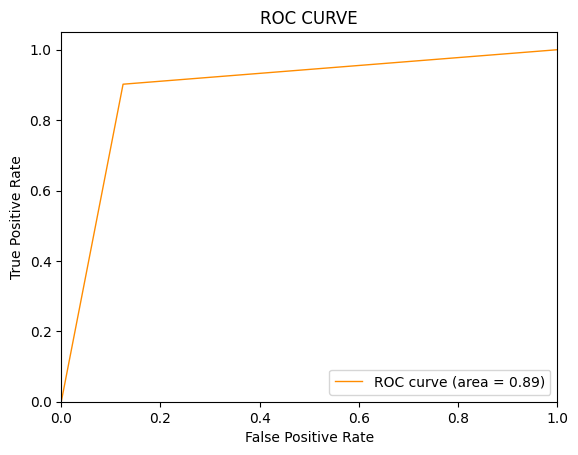

In [97]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [105]:
#Bernoulli Naive Bayes Classifier
from sklearn.naive_bayes import BernoulliNB
Bernoulli = BernoulliNB()
Bernoulli.fit(X_train, Y_train)
y_pred2 = Bernoulli.predict(X_test)

In [107]:
accuracy = accuracy_score(Y_test, y_pred2)
print("Accuracy:", accuracy)
confusion_matrix = sklearn.metrics.confusion_matrix(Y_test, y_pred2)
print("Confusion Matrix:",confusion_matrix)
rocauc = roc_auc_score(Y_test, y_pred2)
print("AUC Score:", rocauc)
f1score = f1_score(Y_test, y_pred2)
print("F1 Score:", f1score)

Accuracy: 0.8773181169757489
Confusion Matrix: [[5238  646]
 [ 816 5217]]
AUC Score: 0.8774773247478771
F1 Score: 0.8771015467383994


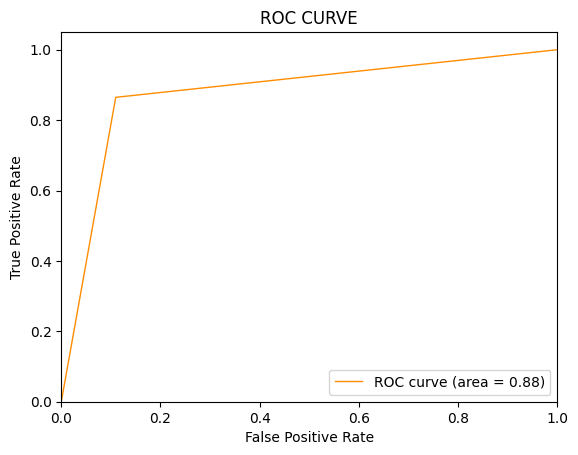

In [102]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [108]:
#SVM (Support Vector Machine)
from sklearn.svm import LinearSVC
SVM = LinearSVC()
SVM.fit(X_train, Y_train)
y_pred3 = SVM.predict(X_test)

In [109]:
accuracy = accuracy_score(Y_test, y_pred3)
print("Accuracy:", accuracy)
confusion_matrix = sklearn.metrics.confusion_matrix(Y_test, y_pred3)
print("Confusion Matrix:",confusion_matrix)
rocauc = roc_auc_score(Y_test, y_pred3)
print("AUC Score:", rocauc)
f1score = f1_score(Y_test, y_pred3)
print("F1 Score:", f1score)

Accuracy: 0.9040026852395737
Confusion Matrix: [[5268  616]
 [ 528 5505]]
AUC Score: 0.9038953329765825
F1 Score: 0.9058746091821623


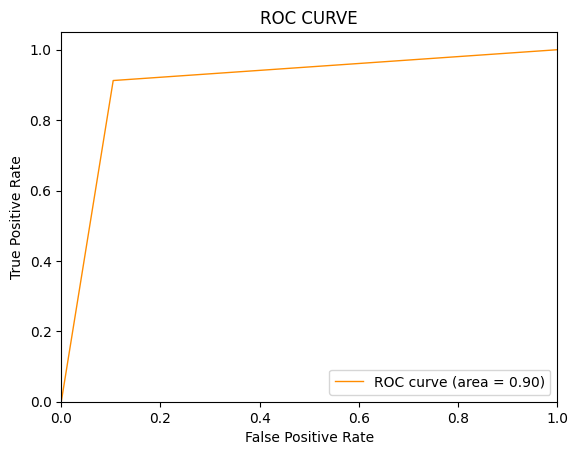

In [110]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [111]:
#Random forests
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(X_train, Y_train)
y_pred4 = RFC.predict(X_test)

In [112]:
accuracy = accuracy_score(Y_test, y_pred4)
print("Accuracy:", accuracy)
confusion_matrix = sklearn.metrics.confusion_matrix(Y_test, y_pred4)
print("Confusion Matrix:",confusion_matrix)
rocauc = roc_auc_score(Y_test, y_pred4)
print("AUC Score:", rocauc)
f1score = f1_score(Y_test, y_pred4)
print("F1 Score:", f1score)

Accuracy: 0.8481161366115633
Confusion Matrix: [[5077  807]
 [1003 5030]]
AUC Score: 0.8482980616579354
F1 Score: 0.8475147430497051


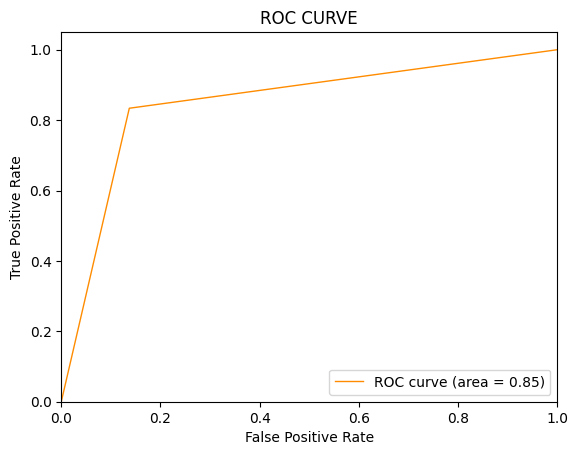

In [113]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred4)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Simple Neural Network Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train_a,y_train,epochs=100, callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))
model_Evaluate(model)
y_pred5 = model.predict(X_test)